# E-commerce Fraud Detection Analysis

### Load libraries

In [1]:
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb

from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix,  roc_auc_score, roc_curve

from skopt import BayesSearchCV

from imblearn.under_sampling import RandomUnderSampler # doctest: +NORMALIZE_WHITESPACE
from imblearn.pipeline import Pipeline # doctest: +NORMALIZE_WHITESPACE

%matplotlib inline

Using TensorFlow backend.


### Load data

Random Forest are used on cleanXG_LR.zip dataset. This data set have 2 type of data X1 and X2 with following specifications:
- General - Preprocessing applied to all files:
    - Features with > 90% data missing or > 90% data with the same value were dropped
    - If possible, categorical variables with 100s of categories were mapped to coaser categoricals
    - Correlation plot analysis done on "V" columns and columns were dropped reduce collinearlity
        - https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id
    - Some "D" columns were normalized for time
    - Aggregate features were added using "magic" technique
        - https://www.kaggle.com/cdeotte/xgb-fraud-with-magic-0-9600#How-the-Magic-Works
    - Dropped TransactionID and TransactionDT

- XGBoost_LR_{train, test}_X_1.pkl ==> 1323 features
    - Full 200 features
	- Dummies created
    - NAs filled with -999
- XGBoost_LR_{train, test}_X_2.pkl ==> 1303 features
    - Removed additional features:
        - Highly correlated "C", "D" features
        - Removed features Chris (1st place winners) removed
        - Removed caterogical features withh 200+ categories even after 1)
    - Dummies created
    - NAs filled with -999


In [2]:
#Load train y data
y = pd.read_pickle("data/train_y.pkl")


In [3]:
#Load train x data
X = pd.read_pickle("data/cleanXG_LR/XGBoost_LR_train_X_1.pkl")

# Replace Nan (currently -999 in the input dataset) with 0:
X = X.replace(-999, 0)

In [4]:
y.shape, X.shape

((590540,), (590540, 1323))

In [5]:
X.head(3)

,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_13,...,DeviceInfo_za409,DeviceInfo_za509,DeviceInfo_za990,DeviceInfo_zeia8,DeviceInfo_zte,DeviceInfo_zte a2017u build/nrd90m,DeviceInfo_zte-z835,DeviceInfo_zte-z956,DeviceInfo_zur70016,DeviceInfo_zuum_zen_i build/lrx21m
0,0.0,70787.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,-5.0,98945.0,0.0,0.0,0.0,-5.0,0.0,0.0,100.0,49.0,...,0,0,0,0,0,0,0,0,0,0
2,-5.0,191631.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,52.0,...,0,0,0,0,0,0,0,0,0,0


### Random Forest - 2 nested train-test split

### Part A: Parameter tuning on training data (A)

In [6]:
# Specify parameters
seed = 123
test_size = 0.3 #Testing percentage in train/test split

In [7]:
# Get a subset of data for debugging (PLEASE SKIP THIS ON ACTUAL RUN)
X = X.iloc[:10000,:]
y = y.iloc[:10000]

In [8]:
# Outer validation for model family comparison: slipt data into training (A) and testing (B)
X_A, X_B, y_A, y_B = train_test_split(X, y, test_size = test_size, random_state = seed)

# Reset all indices
X_A.reset_index(drop = True, inplace = True)
X_B.reset_index(drop = True, inplace = True)
y_A.reset_index(drop = True, inplace = True)
y_A.reset_index(drop = True, inplace = True)

In [9]:
# Inner validation for parameter tuning within a model family: split data into training (C) and testing (D)
# Set up train-test split validation
A_ind = np.arange(len(X_A))
C_ind, D_ind = train_test_split(A_ind, test_size = test_size, random_state = seed)

X_C = X_A.iloc[C_ind,:]
y_C = y_A.iloc[C_ind]


# Reformat index array to 2D list to be used within "cv" context:
# Desired format: [ ( [train_ind_fold1], [test_ind_fold1]) , ([train_ind_fold2], [test_ind_fold2]) ]
C_ind = list(C_ind) #Train
D_ind = list(D_ind) #Test
cv = [(C_ind, D_ind)] #(Train indices, Test indices)
#list(cv)

In [10]:
#Get numeric features that need to be scaled to mean 0 and unit variance and unimodal variables to exclude 
#unimode_list = []
binary_list = []
thres = 5 #5% of feature value is 1
for colname in X_C.columns:
    if len(np.unique(X_C[colname])) == 2:
        binary_list.append(colname)
        #percent_1 = np.sum(X[colname])/len(X[colname])*100

        #if percent_1 < thres:
        #    unimode_list.append(colname)

#print("There are %d/%d features that have almost same value btw fraud vs non-fraud" %(len(unimode_list), len(X.columns)))
print('There are %d/%d features that have binary (2) levels {0,1}' %(len(binary_list), X_C.shape[1]))
    

#List of multivariate numeric features: (Note: We do not scale binary features (values  = {0,1})) 
numeric_features = list(set(X_C.columns.to_list()) - set(binary_list))
print('There are %d/%d numeric features that needs to be scaled' %(len(numeric_features), X_C.shape[1]))

There are 352/1323 features that have binary (2) levels {0,1}
There are 971/1323 numeric features that needs to be scaled


In [11]:
#Build pipeline to include preprocessing step of scaling multivariate numeric features.
numeric_transformer = Pipeline([
        ('scaler', StandardScaler())
    ])

preprocessor = ColumnTransformer([
        ('numericals', numeric_transformer, numeric_features)
    ])


pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('clf', RandomForestClassifier(class_weight = 'balanced', random_state = seed))
    ])


In [12]:
#Set up search space for parameter
params = {   
        'clf__n_estimators': (100,200),
        'clf__max_depth': (20, 25),
        'clf__max_features': ('auto', 'log2', 'sqrt')
    }


In [13]:
rf_tuner = BayesSearchCV(estimator = pipeline, search_spaces = params, scoring = 'roc_auc',\
                          cv = cv, n_jobs = 3, n_iter = 5, verbose = 1, refit = True, random_state = seed)

In [14]:
def status_print(optim_result):    
    all_models = pd.DataFrame(rf_tuner.cv_results_)    
    
    # Get best parameters    
    best_params = pd.Series(rf_tuner.best_params_)
    print(f'Model {len(all_models)}:\nBest ROC-AUC:\
    {np.round(rf_tuner.best_score_, 4)}\nBestparams:{rf_tuner.best_params_}\n')
    
    # Save to csv
    #clf_name = rg_tuner.estimator.__class__.__name__
    #all_models.to_csv(clf_name+"_cv_results.csv")

In [15]:
print('Modeling..')
best_rf = rf_tuner.fit(X_A, y_A, callback = status_print)

Modeling..
Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:   14.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Model 1:
Best ROC-AUC:    0.9507
Bestparams:OrderedDict([('clf__max_depth', 24), ('clf__max_features', 'log2'), ('clf__n_estimators', 109)])

Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:   10.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Model 2:
Best ROC-AUC:    0.9507
Bestparams:OrderedDict([('clf__max_depth', 24), ('clf__max_features', 'log2'), ('clf__n_estimators', 109)])

Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    9.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Model 3:
Best ROC-AUC:    0.9507
Bestparams:OrderedDict([('clf__max_depth', 24), ('clf__max_features', 'log2'), ('clf__n_estimators', 109)])

Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Model 4:
Best ROC-AUC:    0.9507
Bestparams:OrderedDict([('clf__max_depth', 24), ('clf__max_features', 'log2'), ('clf__n_estimators', 109)])

Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    1.5s finished


Model 5:
Best ROC-AUC:    0.9548
Bestparams:OrderedDict([('clf__max_depth', 22), ('clf__max_features', 'log2'), ('clf__n_estimators', 108)])



In [16]:
best_rf.cv_results_ #Note each split is an iteration. No. splits = no. iterations

defaultdict(list,
            {'split0_test_score': [0.9506700520757206,
              0.9473751247603975,
              0.945886352152143,
              0.9445040695902013,
              0.95483569212266],
             'mean_test_score': [0.9506700520757206,
              0.9473751247603975,
              0.945886352152143,
              0.9445040695902013,
              0.95483569212266],
             'std_test_score': [0.0, 0.0, 0.0, 0.0, 0.0],
             'rank_test_score': [2, 3, 4, 5, 1],
             'mean_fit_time': [1.3099994659423828,
              2.594973564147949,
              1.744997501373291,
              1.5569984912872314,
              1.1409919261932373],
             'std_fit_time': [0.0, 0.0, 0.0, 0.0, 0.0],
             'mean_score_time': [0.13299870491027832,
              0.13700079917907715,
              0.11000514030456543,
              0.13899946212768555,
              0.11100316047668457],
             'std_score_time': [0.0, 0.0, 0.0, 0.0, 0.0],
    

In [17]:
best_rf.best_params_

OrderedDict([('clf__max_depth', 22),
             ('clf__max_features', 'log2'),
             ('clf__n_estimators', 108)])

### Part B: Retrain model on entire training data (A) and apply on validation data (B)

##### Build Model

In [18]:
# Proprocess data on A - feature scaling

# Step 1: get list of feature to scale
# Numeric features are those that have more than 2 levels.
# We will scale these features to have mean 0 and unit variance and unimodal variables to exclude 

numeric_features = []
thres = 5 #5% of feature value is 1
for colname in X_A.columns:
    if len(np.unique(X_A[colname])) > 2:
        numeric_features.append(colname)

print('There are %d/%d numeric features that needs to be scaled' %(len(numeric_features), X_A.shape[1]))

# Step 2: train scaler using training data (A) only
scaler = StandardScaler().fit(X_A[numeric_features])
    
# Step 3: apply scaler on  training data (A) and testing data (B)
X_A.loc[:,numeric_features] = scaler.transform(X_A.loc[:,numeric_features])
X_B.loc[:,numeric_features] = scaler.transform(X_B.loc[:,numeric_features])

# Sanity check:
rand_ind_check = np.random.randint(len(numeric_features))
print('mean = 0 and variance = 1')
print(np.mean(X_A.loc[:,numeric_features[rand_ind_check]]), np.std(X_A.loc[:,numeric_features[rand_ind_check]])**2)

There are 152/1323 numeric features that needs to be scaled


C:\Users\MyPC\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\MyPC\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


mean = 0 and variance = 1
-4.42503176957741e-17 1.0000000000001048


In [19]:
X_A.head(2)

,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_13,...,DeviceInfo_za409,DeviceInfo_za509,DeviceInfo_za990,DeviceInfo_zeia8,DeviceInfo_zte,DeviceInfo_zte a2017u build/nrd90m,DeviceInfo_zte-z835,DeviceInfo_zte-z956,DeviceInfo_zur70016,DeviceInfo_zuum_zen_i build/lrx21m
0,-0.137707,0.047324,-0.10142,0.061866,4.605739,-0.701071,-0.098922,0.100737,0.180226,0.564052,...,0,0,0,0,0,0,0,0,0,0
1,0.583651,-0.601137,-0.10142,0.061866,-0.351695,0.359699,-0.098922,0.100737,0.180226,-1.659100,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# Build model using best hyperparameters found and all training data (A)
rf = RandomForestClassifier(
                             max_depth = best_rf.best_params_['clf__max_depth'],
                             max_features = best_rf.best_params_['clf__max_features'],
                             n_estimators = best_rf.best_params_['clf__n_estimators'],
                             class_weight = 'balanced',
                             random_state = seed)
rf.fit(X_A, y_A)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=22, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=108,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

##### Feature Importance

In [21]:
# Saving feature names for later use
feature_list = list(X_A.columns)
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: C1                   Importance: 0.02
Variable: C2                   Importance: 0.02
Variable: C6                   Importance: 0.02
Variable: C11                  Importance: 0.02
Variable: id_01                Importance: 0.01
Variable: id_02                Importance: 0.01
Variable: id_05                Importance: 0.01
Variable: id_06                Importance: 0.01
Variable: id_14                Importance: 0.01
Variable: id_19                Importance: 0.01
Variable: id_20                Importance: 0.01
Variable: id_32                Importance: 0.01
Variable: TransactionAmt       Importance: 0.01
Variable: card1                Importance: 0.01
Variable: card2                Importance: 0.01
Variable: card3                Importance: 0.01
Variable: card5                Importance: 0.01
Variable: addr1                Importance: 0.01
Variable: addr2                Importance: 0.01
Variable: C4                   Importance: 0.01
Variable: C7                   Importanc

Variable: DeviceInfo_bv6000    Importance: 0.0
Variable: DeviceInfo_bv7000    Importance: 0.0
Variable: DeviceInfo_bv8000pro Importance: 0.0
Variable: DeviceInfo_c1904     Importance: 0.0
Variable: DeviceInfo_c2104     Importance: 0.0
Variable: DeviceInfo_c6603     Importance: 0.0
Variable: DeviceInfo_c6743 build/lmy47v Importance: 0.0
Variable: DeviceInfo_c6903     Importance: 0.0
Variable: DeviceInfo_c6906     Importance: 0.0
Variable: DeviceInfo_c6906 build/14.6.a.1.236 Importance: 0.0
Variable: DeviceInfo_cam-l23   Importance: 0.0
Variable: DeviceInfo_clt-l09   Importance: 0.0
Variable: DeviceInfo_coolpad   Importance: 0.0
Variable: DeviceInfo_covet build/nrd90m Importance: 0.0
Variable: DeviceInfo_cph1607   Importance: 0.0
Variable: DeviceInfo_cph1701   Importance: 0.0
Variable: DeviceInfo_cph1723   Importance: 0.0
Variable: DeviceInfo_cro       Importance: 0.0
Variable: DeviceInfo_d2306     Importance: 0.0
Variable: DeviceInfo_d2306 build/18.6.a.0.182 Importance: 0.0
Variable: De

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

##### Test model and report performance metrics

In [22]:
# Apply model on testing data (B) and report performance metrics:
y_B_pred_labels = rf.predict(X_B)

0.9629801739130434


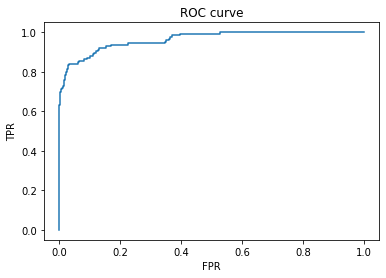

In [23]:
# Get probability of class 1. Note this step is applicable for random forest only when there is no cut-off value in the labels to get AUC.
y_B_pred_prob = rf.predict_proba(X_B)

print(roc_auc_score(y_B, y_B_pred_prob[:,1]))

fpr, tpr, _ = roc_curve(y_B, y_B_pred_prob[:,1])

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

Confusion Matrix (Note: this result is not a good representation as it assumes 2 classes weight the same)


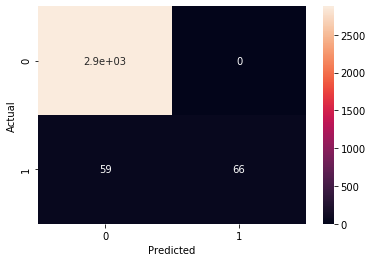

In [26]:
print('Confusion Matrix (Note: this result is not a good representation as it assumes 2 classes weight the same)')


data = {'y_Actual':    list(y_B),
        'y_Predicted': list(y_B_pred_labels)
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sb.heatmap(confusion_matrix, annot=True)
plt.show()